In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [3]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.233
Iter 2/50 - Loss: 1.196
Iter 3/50 - Loss: 1.156
Iter 4/50 - Loss: 1.115
Iter 5/50 - Loss: 1.072
Iter 6/50 - Loss: 1.028
Iter 7/50 - Loss: 0.983
Iter 8/50 - Loss: 0.939
Iter 9/50 - Loss: 0.895
Iter 10/50 - Loss: 0.852
Iter 11/50 - Loss: 0.810
Iter 12/50 - Loss: 0.770
Iter 13/50 - Loss: 0.732
Iter 14/50 - Loss: 0.694
Iter 15/50 - Loss: 0.656
Iter 16/50 - Loss: 0.618
Iter 17/50 - Loss: 0.580
Iter 18/50 - Loss: 0.542
Iter 19/50 - Loss: 0.503
Iter 20/50 - Loss: 0.465
Iter 21/50 - Loss: 0.426
Iter 22/50 - Loss: 0.388
Iter 23/50 - Loss: 0.351
Iter 24/50 - Loss: 0.314
Iter 25/50 - Loss: 0.278
Iter 26/50 - Loss: 0.244
Iter 27/50 - Loss: 0.212
Iter 28/50 - Loss: 0.181
Iter 29/50 - Loss: 0.153
Iter 30/50 - Loss: 0.128
Iter 31/50 - Loss: 0.104
Iter 32/50 - Loss: 0.083
Iter 33/50 - Loss: 0.065
Iter 34/50 - Loss: 0.048
Iter 35/50 - Loss: 0.034
Iter 36/50 - Loss: 0.022
Iter 37/50 - Loss: 0.012
Iter 38/50 - Loss: 0.005
Iter 39/50 - Loss: 0.000
Iter 40/50 - Loss: -0.002
Iter 41/

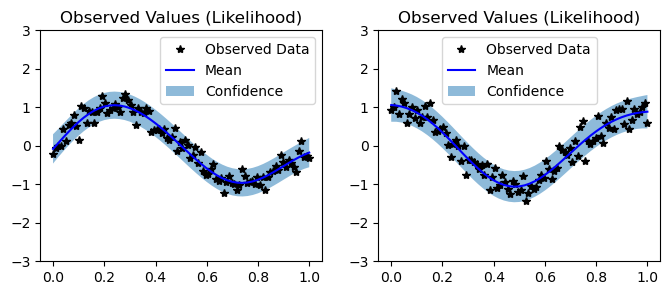

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None